In [322]:
#| echo: false
#| output: false
%load_ext dotenv
%dotenv

from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import os, json, requests, random

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

with open('data/current_events.json', 'r') as f: events = json.load(f)
E = np.load('data/embeddings.npy')


def get_embedding(l, key = None, model = 'text-embedding-3-small', dimensions = None):
    """
    Calls OpenAPI's embedding API to embed string `s`.
    l: list of strings to embed
    key: OpenAPI key
    model: OpenAPI model to use
    """
    if key is None: key = os.environ['OAI_KEY']
    headers = {
        'Content-Type': 'application/json',
        'Authorization': 'Bearer ' + key,
    }

    json_data = {
        'input': l,
        'model': model,
    }
    if dimensions is not None: json_data['dimensions'] = dimensions

    response = requests.post('https://api.openai.com/v1/embeddings', headers=headers, json=json_data)

    if response.status_code != 200 or 'embedding' not in response.text:
        raise Exception(f'Error getting embedding: {response.text}')
    
    return [i['embedding'] for i in response.json()['data']]

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


I am currently a grad student at the University of Michigan and like to attend seminars, lectures, and social events when I can. However, I often attend the same weekly seminars because sifting through all events (about 400/week on avgerage) to find ones that interest me is very time-consuming. Last semester, I tried feeding the events to ChatGPT and [asking for recommendations](https://emiliocantuc.github.io/umich-events-gpt/), but they were not great.


So, given it's break, I want to hack together a simple recommender system to do a better job. The goal is to get to an MVP that other students can use this weekend and iterate on it during the semester. Let's see what we can come up with.

## Overview

I want to keep the recommender as simple, hackable, and low-maintinance as possible. We'll start with content-based filtering, where users are recommended similar events to ones they have previously enjoyed. To do so, we need a way for users to give feedback on events and a way of determining how similar two events are.

For feedback, we can allow users to downvote, upvote, and log if they add an event to their calendar. 

To measure similarity we'll represent our events as strings, obtain their [embeddings](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526), and use take cosine distance between them. To avoid tuning and hosting our own model, we'll turn to OpenAI's embedding [API](https://platform.openai.com/docs/guides/embeddings).

Because I'd like to implement changes quickly and don't expect more than a handful of users, the backend will be a simple Pyton-Flask-SQLite CRUD app.As to the data, the university's event page, [Happening @ Michigan](https://events.umich.edu/), is great. It provides openly available endpoints to fetch daily, weekly, and monthly events with all of their details in JSON format. Great! No scrapping is necessary. We can simply run a cronjob to fetch the events of the day or week to keep the system up-to-date [^1]. 

[^1]: Unfortunatly not all departments / organizations post their events to the main events feed, but finding and maintaining other feeds would be very time consuming.

## Embedding events

Traditionally, one of the biggest challenges in recommender systems was coming up with vector representations of the items (movies, products, events, etc.) such that distances between are semantically meaningful. Luckily, it's now very easy and convenient to throw items to a neural network and get such embeddings.  

First, let's take a look at three events and how we might represent their most relevant data fields as strings:

In [201]:
#| code-summary: Stringify event 
#| code-fold: true
day_of_week = lambda datetime_str: datetime.strptime(datetime_str, '%Y%m%dT%H%M%S').strftime('%A')
gget = lambda e, k, v: e.get(k, None) if e.get(k, None) is not None else v

def stringify_event(e):
    limit = lambda s, n: s if len(s) < n else s[:n-3] + '...'
    sponsors = [gget(s, 'group_name', '') for s in gget(e, 'sponsors', {})]
    maize_group = e.get('maizepages_import', {}).get('maizepages_group_name')
    if maize_group: sponsors.append(maize_group)
    o = [
        f"{e['event_type']}:{limit(gget(e, 'combined_title', ''), 200)}",
        f"{limit(gget(e, 'description', ''), 800)}",
        f"Where:{e['location_name']}",
        f"When:{day_of_week(e['datetime_start'])} {e['time_start'].split(':')[0]}",
    ]
    if sponsors: o.append(f"Sponsors:{', '.join(sponsors)}")
    return '\n'.join(o)

In [202]:
#| echo: false
ix = 21
sim_ixs = (E @ E.T)[ix].argsort()
ixs = [ix, sim_ixs[0], sim_ixs[-10]]
for e in ixs: print(f'{"="*50}\n{stringify_event(events[e])}')

Exhibition:Sea Monsters
The film follows a curious and adventurous Dolichorhynchops – familiarly known as a ‘dolly’ – as she travels through the most dangerous oceans in history. Along the way, she encounters long-necked plesiosaurs, giant turtles, enormous fish, fierce sharks, and the most dangerous sea monster of all– the mosasaur.
Where:Museum of Natural History
When:Sunday 12
Sponsors:Planetarium & Dome Theater at the Museum of Natural History
Exercise / Fitness:Chair Aerobics
Lifetime Fitness classes are offered at Briarwood Mall in the JCPenney wing. No experience necessary. Classes are specifically designed for older adults, however, everyone is welcome. LTF classes are free, however, please consider making a $2/person per class donation as our classes are funded strictly through donations. No registration is necessary, simply attend when it fits your schedule. Chair Aerobics classes are carefully structured to include a warm-up, a pre-aerobic stretch, sitting and standing aerob

Note that we only include the day of the week and the start hour in the date to make it easier for the text model to make sense of. For now, we'll use OpenAI's `text-embedding-3-small` model, but we can try others later.

We now have a normalized 1536-dimentional vector representing each event and can use dot products to determine similarity. For example, for the events above we have:

In [203]:
(E[ixs] @ E[ixs].T)[0]

array([1.00000009, 0.09336403, 0.61303273])

which makes sense since the first event is most similar to itself and then to the last event (which is also "sea themed").

Before moving on, we should visualize the embeddings to make sure they are not collapsed. 

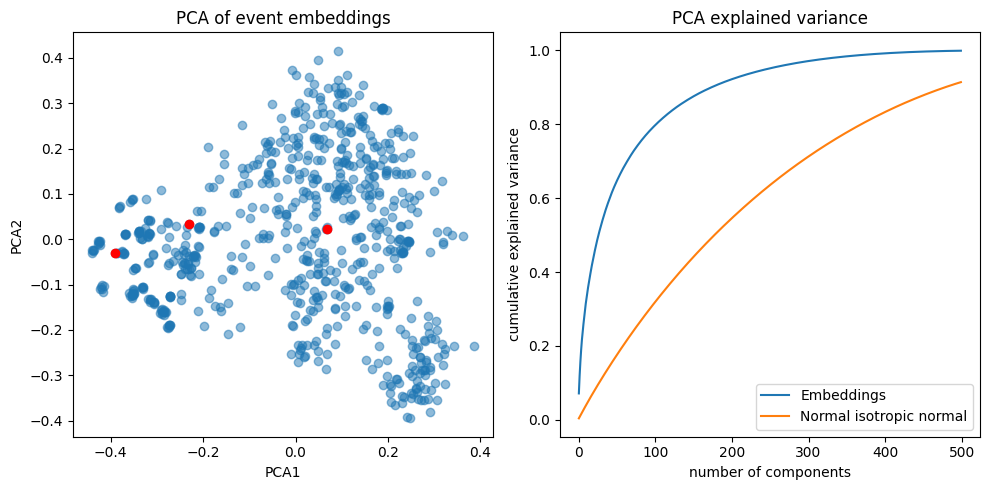

In [22]:
#| echo: false
#| fig-cap: The first two principal components have some structure (example events from above displayed in red). Also observe that almost all of the variance can be explained by the first 500/1535 components.  
f, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 5))

pca = PCA(n_components=500)
pca.fit(E)
ax1.plot(np.cumsum(pca.explained_variance_ratio_), label = 'Embeddings')

# reference curves
pca = PCA(n_components=500)
pca.fit(np.random.randn(*E.shape))
ax1.plot(np.cumsum(pca.explained_variance_ratio_), label = 'Normal isotropic normal')

ax1.legend()
ax1.set_xlabel('number of components'); ax1.set_ylabel('cumulative explained variance')
ax1.set_title('PCA explained variance')

pca = PCA(n_components=2)
E2 = pca.fit_transform(E)
ax2.scatter(E2[:,0], E2[:,1], alpha=0.5)
ax2.scatter(E2[ixs,0], E2[ixs,1], c='red')

ax2.set_xlabel('PCA1'); ax2.set_ylabel('PCA2')

ax2.set_title('PCA of event embeddings')

f.tight_layout()

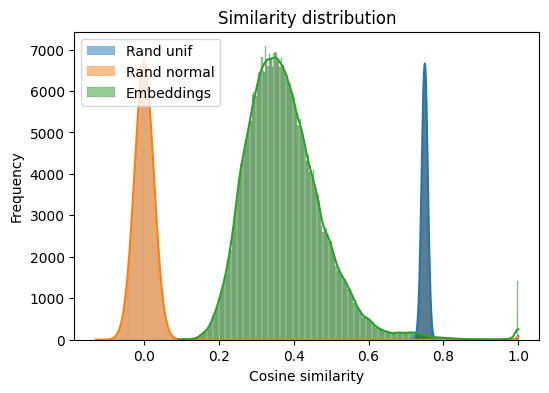

In [ ]:
#| code-summary: Visualize similarity distribution
#| echo: false
#| fig-cap: Another sanity check:\ the cosine similarities are nicely spread out and not clustered around zero, unlike random normal vectors.
plt.figure(figsize=(6, 4))
R = np.random.uniform(size=E.shape)
R = R / np.linalg.norm(R, axis=1)[:, None]
sns.histplot((R @ R.T).flatten(), label='Rand unif', kde=True)

R = np.random.normal(size=E.shape)
R = R / np.linalg.norm(R, axis=1)[:, None]
sns.histplot((R @ R.T).flatten(), label='Rand normal', kde=True)

sns.histplot((E @ E.T).flatten(), label='Embeddings', kde=True)

plt.legend()
plt.title('Similarity distribution')
plt.xlabel('Cosine similarity')
plt.ylabel('Frequency')
plt.show()

## KNN recommender

If we encode downvotes as `-1`, upvotes as `1`, and "adds to calendar" as `2`, we could implement a very simple recommender. Given a user and a new event, look up the event's k-nearest neighbors (using embeddings and dot products) with ratings by the user and return the average rating. This average rating can be considered the estimated rating the user would give to the new event.  Repeat for each new event and return events with the highest predicted ratings.

This system would be fairly simple to spin up, and we could even keep the KNN lookup constant by using approximate methods like those provided in [`faiss`](https://github.com/facebookresearch/faiss) or any of the many vector databases.

However, we have to keep around a growing list of past events (at least their embeddings) and user ratings. To avoid running out of a cheap VM's disk space (being very, very optimistic about user count), we could prune the oldest ratings once in a while or come up with some other simple scheme. But I wanted to try something else out.

## Interest embeddings

What if we maintain a single embedding per user that represents their interests? This coud be as simple as the weighted average of all events the user has interacted with. To avoid storing all past embeddings and allow for changing preferences, we can use an [exponentially moving average](https://en.wikipedia.org/wiki/Exponential_smoothing#Double_exponential_smoothing_(Holt_linear)):

```python
usr_emb = (alpha * usr_emb) + (1-alpha) * w * event_emb
```

where `w` is the weight we give to the embedding of the event the user interacted with (`event_emb`) and `alpha` is tuneable parameter. This method is purely geometric: we move our interest embedding towards (`w > 0`) events we like and away from (`w < 0`) those we dislike. 

While straightforward, this method has a few immediate drawbacks:

- **Preference dilution:** we are blending all user interests into a single vector, potentially losing the multi-faceted nature of preferences. If a user has diverse interests, the averaged embedding could become less meaningful. Strong but infrequent interests will get washed out by more frequent but less important interactions. 

- **Param sensitivity:** The `alpha` parameter is critical but could be difficult to tune. Too high and system is slow to adapt to changing preferences. Too low and system "forgets" long-term interests too quickly.

- **Outlier sensitivity:** One-off interactions could disproportionately shift interest embeddings.

Along with the usual [cold-start](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)), explanability, and other traditional recommerder challanges. 

To alliviate preference dilution and the cold-start problem, we can let users manually input a list of interests, embed and use them along with `usr_emb` to make recommendations.

In [209]:
def init_usr_emb_fn(size = E.shape[1]):
    emb = np.random.normal(size = size)
    return emb / np.linalg.norm(emb)

class User:
    def __init__(self, usr_id, init_usr_emb_fn = init_usr_emb_fn):
        self.usr_id = usr_id
        self.usr_emb = init_usr_emb_fn()
        self.interests = {}
    
    def add_interests(self, interests, interest_embs = None):
        # Add interests and their embeddings to user
        assert isinstance(interests, list) and isinstance(interests[0], str)
        if interest_embs is None: interest_emb = get_embedding(interests)
        for i, e in zip(interests, interest_emb): self.interests[i] = e


class Recommender:

    def __init__(self, events, event_embs, alpha, dedup = False):
        self.events = events
        self.event_embs = event_embs
        self.alpha = alpha
        self.dedup = dedup

    def recommend(self, user, n):
        # Calculate cosine similarity between user and all events
        sim = (user.usr_emb[None, :] @ self.event_embs.T).flatten()
        # Sort by similarity and return top n
        return [self.events[i] for i in sim.argsort()[-n:]]

    def record_feedback(self, usr, event_id, rating):
        # Update usr_emb with weighted EMA
        w = {'up': 1., 'down': -1., 'cal': 2.}[rating]
        event_emb = self.event_embs[event_id]
        usr.usr_emb = self.alpha * usr.usr_emb + (1 - self.alpha) * w * event_emb
        usr.usr_emb /= np.linalg.norm(usr.usr_emb)



In [205]:
r = Recommender(events, E, 0.1)
usr = User(0, init_usr_emb_fn=lambda: E[10])
for e in r.recommend(usr, 2): print(stringify_event(e))

Exhibition:A Material World
This exhibition seeks to explore the intersection of two seemingly disparate fields—engineering and the visual arts—through the lens of Materials Science and Engineering (MSE). While both disciplines are extensively studied and practiced, their convergence is often overlooked. With this body of work, artist Trevor Balduck aim's to bridge that gap by presenting MSE not only as a technical pursuit but as a source of inspiration and beauty within the realm of artistic expression.

The eight pieces in this exhibit form a cohesive 2x4 grid measuring 4x8 feet, guiding viewers through a chronological exploration of the processes involved in materials-focused research. Each work is an abstraction of the actions and methodologies found in a materials lab—transformed into visual representations...
Where:Pierpont Commons
When:Monday 09
Sponsors:University Unions
Exhibition:A Material World
This exhibition seeks to explore the intersection of two seemingly disparate fie

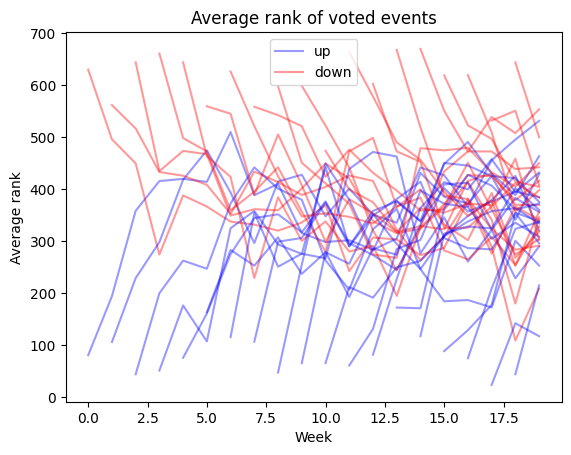

In [359]:
alpha = 0.75
n_up, n_down = 10, 10
n_weeks = 20

# set seed
# random.seed(0)
# np.random.seed(0)

r = Recommender(events, E, alpha)
usr = User(0)

# 
data = [{
    # What events we up/down vote each week
    'up': random.sample(range(len(events)), n_up),
    'down': random.sample(range(len(events)), n_down),
    'up avg. rank': {}, # judging week -> avg rank
    'down avg. rank': {},
    } for week in range(n_weeks)
]


for w_i, week_data in enumerate(data):

    # Choose n_up random events to upvote, n_down to downvote, and randomize the order in which we vote
    up_events = week_data['up']
    down_events = week_data['down']
    voted = up_events + down_events
    random.shuffle(voted)

    for i in voted:
        rating = 'up' if i in up_events else 'down'
        r.record_feedback(usr, i, rating)

    sims = (usr.usr_emb[None, :] @ E.T).flatten()

    # Get all ranks at once (more efficient)
    sorted_indices = np.argsort(sims)[::-1]  # descending order
    ranks = {idx: rank for rank, idx in enumerate(sorted_indices)}

    # Log info for all preceding weeks
    for w_j, w_data in enumerate(data[:w_i+1]):
        for evs, field in zip([w_data['up'], w_data['down']], ['up avg. rank', 'down avg. rank']):
            avg_rank = np.mean([ranks[e] for e in evs])
            w_data[field][w_i] = avg_rank

for week in data:
    # sort in case keys are not in order
    week['up avg. rank'] = dict(sorted(week['up avg. rank'].items()))
    week['down avg. rank'] = dict(sorted(week['down avg. rank'].items()))
    plt.plot(week['down avg. rank'].keys(), week['up avg. rank'].values(), label='up', alpha = 0.4, color = 'blue')
    plt.plot(week['down avg. rank'].keys(), week['down avg. rank'].values(), label='down', alpha = 0.4, color = 'red')

plt.title('Average rank of voted events')
plt.xlabel('Week')
plt.ylabel('Average rank')
plt.legend(['up', 'down'])
plt.show()

In [ ]:
dists_from_best = []
stds = []

for week_data in data:
    for vote in ['up', 'down']:
        rank_path = np.array(list(week_data[f'{vote} avg. rank'].values()))
        dist_from_best = np.abs(rank_path - 0)
        std = np.std(rank_path)
        dists_from_best.append(np.mean(dist_from_best)) # average distance from best for this path
        stds.append(std)

np.mean(dists_from_best), np.mean(stds)

(354.583897518922, 86.9182523360108)

In [407]:
def alpha_analysis(alpha, n_up, n_down, n_weeks, seed):

    # set seed
    random.seed(seed)
    np.random.seed(seed)

    r = Recommender(events, E, alpha)
    usr = User(0)

    # 
    data = [{
        # What events we up/down vote each week
        'up': random.sample(range(len(events)), n_up),
        'down': random.sample(range(len(events)), n_down),
        'up avg. rank': {}, # judging week -> avg rank
        'down avg. rank': {},
        } for week in range(n_weeks)
    ]


    for w_i, week_data in enumerate(data):

        # Choose n_up random events to upvote, n_down to downvote, and randomize the order in which we vote
        up_events = week_data['up']
        down_events = week_data['down']
        voted = up_events + down_events
        random.shuffle(voted)

        for i in voted:
            rating = 'up' if i in up_events else 'down'
            r.record_feedback(usr, i, rating)

        sims = (usr.usr_emb[None, :] @ E.T).flatten()

        # Get all ranks at once (more efficient)
        sorted_indices = np.argsort(sims)[::-1]  # descending order
        ranks = {idx: rank for rank, idx in enumerate(sorted_indices)}

        # Log info for all preceding weeks
        for w_j, w_data in enumerate(data[:w_i+1]):
            for evs, field in zip([w_data['up'], w_data['down']], ['up avg. rank', 'down avg. rank']):
                avg_rank = np.mean([ranks[e] for e in evs])
                w_data[field][w_i] = avg_rank

    dists_from_best = []
    stds = []

    for week_data in data:
        for vote in ['up', 'down']:
            rank_path = np.array(list(week_data[f'{vote} avg. rank'].values()))
            dist_from_best = np.abs(rank_path - 0 if vote == 'up' else len(events))
            std = np.std(rank_path)
            dists_from_best.append(np.mean(dist_from_best)) # average distance from best for this path
            stds.append(std)

    return np.mean(dists_from_best), np.mean(stds)

0.0 (525.3817919581923, 54.312783190192405)
0.1 (524.7565810337861, 54.40225715660267)
0.2 (523.8998929054262, 54.31565365698141)
0.30000000000000004 (523.22627572986, 54.921965332168554)
0.4 (522.0197097982534, 56.9794133329025)
0.5 (517.920334323743, 63.83384846773788)
0.6 (510.77933021982096, 76.76949824317037)
0.65 (505.1734862030814, 82.91906707881091)
0.7 (497.86132063505374, 86.16086130606831)
0.75 (489.63047914320157, 83.28806251339601)
0.8 (480.96097333611095, 74.1379805811321)
0.8500000000000001 (472.4797047921441, 57.73146208392848)
0.9 (468.83150753203836, 40.70336615649343)
0.91 (468.96931998185426, 37.72783321376087)
0.92 (469.2937768535859, 34.96153355536315)
0.93 (469.94660746600965, 31.983098978180283)
0.9400000000000001 (470.9774236244384, 29.232513648301023)
0.9500000000000001 (472.51639232638064, 26.610025350388753)
0.96 (474.89242325752383, 23.422398635767543)
0.97 (478.74227399026415, 19.704579402033552)
0.98 (485.25596851188027, 14.778369606469013)
0.99 (496.7737

Text(0, 0.5, 'Mean std')

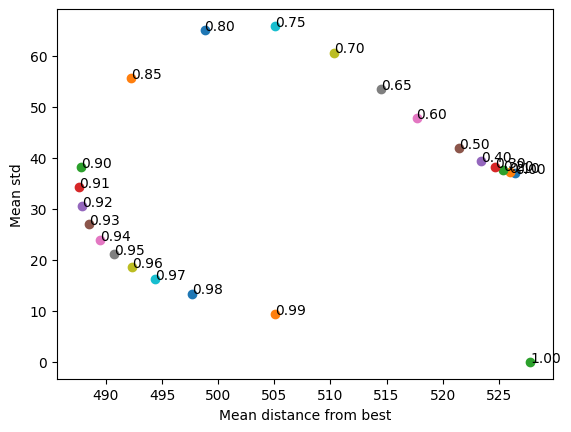

In [408]:
# alphas 0, 0.1, ..., 1
alphas = np.concatenate([np.linspace(0, 0.5, 6), np.linspace(0.6, 0.9, 7), np.linspace(0.91, 1.0, 10)])

for alpha in alphas:
    mean_dists, mean_stds = [], []
    for seed in range(30):
        mean_dist_from_best, mean_std = alpha_analysis(alpha, 20, 20, 20, seed)
        mean_dists.append(mean_dist_from_best)
        mean_stds.append(mean_std)

    mean_dist_from_best, mean_std = np.mean(mean_dists), np.mean(mean_stds)
    plt.text(mean_dist_from_best, mean_std, f'{alpha:.2f}')
    plt.scatter(mean_dist_from_best, mean_std)

    print(alpha, alpha_analysis(alpha, 10, 10, 20, 0))
plt.xlabel('Mean distance from best')
plt.ylabel('Mean std')

0.0 (525.3817919581923, 54.312783190192405)
0.1 (524.7565810337861, 54.40225715660267)
0.2 (523.8998929054262, 54.31565365698141)
0.30000000000000004 (523.22627572986, 54.921965332168554)
0.4 (522.0197097982534, 56.9794133329025)
0.5 (517.920334323743, 63.83384846773788)
0.6 (510.77933021982096, 76.76949824317037)
0.65 (505.1734862030814, 82.91906707881091)
0.7 (497.86132063505374, 86.16086130606831)
0.75 (489.63047914320157, 83.28806251339601)
0.8 (480.96097333611095, 74.1379805811321)
0.8500000000000001 (472.4797047921441, 57.73146208392848)
0.9 (468.83150753203836, 40.70336615649343)
0.91 (468.96931998185426, 37.72783321376087)
0.92 (469.2937768535859, 34.96153355536315)
0.93 (469.94660746600965, 31.983098978180283)
0.9400000000000001 (470.9774236244384, 29.232513648301023)
0.9500000000000001 (472.51639232638064, 26.610025350388753)
0.96 (474.89242325752383, 23.422398635767543)
0.97 (478.74227399026415, 19.704579402033552)
0.98 (485.25596851188027, 14.778369606469013)
0.99 (496.7737

Text(0, 0.5, 'Mean std')

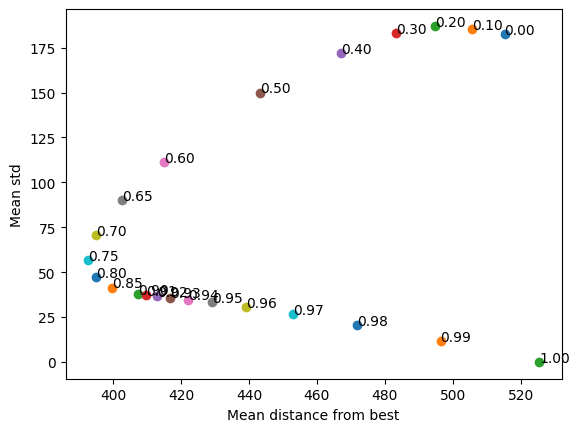

In [411]:
# alphas 0, 0.1, ..., 1
alphas = np.concatenate([np.linspace(0, 0.5, 6), np.linspace(0.6, 0.9, 7), np.linspace(0.91, 1.0, 10)])

for alpha in alphas:
    mean_dists, mean_stds = [], []
    for seed in range(30):
        mean_dist_from_best, mean_std = alpha_analysis(alpha, 1, 1, 20, seed)
        mean_dists.append(mean_dist_from_best)
        mean_stds.append(mean_std)

    mean_dist_from_best, mean_std = np.mean(mean_dists), np.mean(mean_stds)
    plt.text(mean_dist_from_best, mean_std, f'{alpha:.2f}')
    plt.scatter(mean_dist_from_best, mean_std)

    print(alpha, alpha_analysis(alpha, 10, 10, 20, 0))
plt.xlabel('Mean distance from best')
plt.ylabel('Mean std')

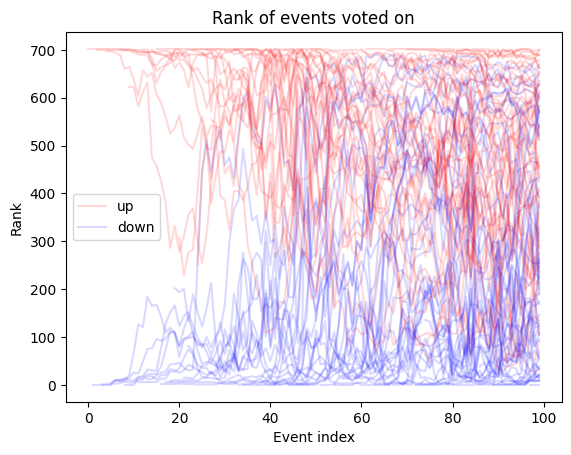

In [442]:
r = Recommender(events, E, alpha = 0.75)
usr = User(0)

n_weeks = 100

events_to_rank_paths = {}
events_to_vote_type = {}

shuffled_events = list(range(len(events)))
random.shuffle(shuffled_events)

for t, event_ix in enumerate(shuffled_events[:n_weeks]):

    # choose random vote
    vote = random.choice(['up', 'down'])
    events_to_vote_type[event_ix] = vote

    # record feedback
    r.record_feedback(usr, event_ix, vote)

    sims = (usr.usr_emb[None, :] @ E.T).flatten()

    # Get all ranks at once (more efficient)
    sorted_indices = np.argsort(sims)[::-1]  # descending order
    ranks = {idx: rank for rank, idx in enumerate(sorted_indices)}

    events_to_rank_paths[event_ix] = []

    # Get rank of event_ix
    for e_ix in events_to_rank_paths:
        events_to_rank_paths[e_ix].append(ranks[e_ix])


mean_dev_from_best = []


for event_ix in events_to_rank_paths:
    rank_path = events_to_rank_paths[event_ix]
    vote = events_to_vote_type[event_ix]
    
    best_rank = 0 if vote == 'up' else len(events)
    # dev_from_best = np.abs(rank_path - best_rank)
    # mean_dev_from_best.append(np.mean(dev_from_best))


    t = np.arange(shuffled_events.index(event_ix), n_weeks)
    plt.plot(t, rank_path, label = vote, alpha = 0.15, color = 'blue' if vote == 'up' else 'red')

    
plt.legend(['up', 'down'])
plt.xlabel('Event index')
plt.ylabel('Rank')
plt.title('Rank of events voted on')
plt.show()


## Tuning

In [ ]:
# Ask chatGPT to take on personas and vote on events 



## Implementation

Assume we have embedded and clustered the bunch of past events and have the centroids. The basic idea is to fetch the events for the upcoming week Sundays and embed them. We then compute their distances to the centroids (or even the weights) and store them (the NumPy arrays as blobs in the db). And those are the only things we batch. 

I drew some inspiration and referenced from karpathy's [arxiv-sanity lite](https://github.com/karpathy/arxiv-sanity-lite/tree/master). For auth, I decided to go with [Signin With Google](https://developers.google.com/identity/gsi/web/guides/overview) as the university is on GSuite. Users can also join a community mailing list to get reminded weekly when recommendations are ready.  

The code is openly available [here](https://github.com/emiliocantuc/wolverine-events) and site hosted [here](https://mywolverine.events).

## A lot of room

for improvement. For example:

- Once the clusters and centroids are computed, there is no way to change them. Either make sure they are good enough so that we never have to change them or come up with something different. 
- Find a way to set parameters (learning rate, inv. temperature) in a more principled way, or test thoroughly. Should each user have their own learning rate?

And I'm sure I'll come up with others.